# Prototype Pipeline for PSSM network (cont'd)
The aim of this bare-bones pipeline is to be the prototype pipeline for retraining jnet in python. It uses only PSSM information, leaving out the HMM profiles for now. Reason PSSM profiles are used is because PSSM profiles are readily available. HMM profiles not available in retr231 folder.
The following list outlines the key steps in the pipeline:

### First notebook (PSSM_parse.ipynb)
1. load PSSM matrices of training and blind-test sets (DONE)

2. incorporate DSSP information of training and blind-test set (DONE)

### Second notebook (PSSM_patternify.ipynb)

3. Generate patterns from PSSM profiles using sliding window (DONE)

### Third notebook (PSSM_linearize.ipynb)

4. linearize patterns (DONE)

### **Fourth notebook (PSSM_net.ipynb)**

5. write and train ML model

6. make predictions on blind-test set

7. score accuracy

Import core modules

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import pickle

# Preprocssing stage - imputation and one hot encoding

Load datasets

In [8]:
data_path = '/homes/2472402/data/linearized_train_data.pkl'
data = pickle.load(open( data_path, 'rb' ))

Preprocess test, validation, and train datasets. This includes one-hot encoding of dssp information.

In [18]:
# simple imputation
imp = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0) # NaN with 0, a number that virtually does not occur in the squashed matrix
df = pd.DataFrame(imp.fit_transform(data))

# separate target (column named 'dssp') from predictors
X, y = df.iloc[:,:-1], df.iloc[:,-1] 

# one hot encoding for y and y_test
# important to supply categories argument, otherwise it is random assignment of which column represents H, E, and -
enc = OneHotEncoder(handle_unknown='ignore', sparse=False, categories = [['H','E','-']])
def one_hot(y):
    y_as_col = y.values.reshape(-1,1)
    y_one_hot = pd.DataFrame(enc.fit_transform(y_as_col)) # only transform, do not call fit_transform
    return y_one_hot

y = one_hot(y) # transform y from 1 to 3 columns

Save the data

In [19]:
# save the data
with open('/homes/2472402/data/preprocessed_train_data.pkl', 'wb') as f:
    pickle.dump([X,y], f, protocol=pickle.HIGHEST_PROTOCOL)

# Neural network training loop

Load input data

In [20]:
[X, y] = pickle.load(open('/homes/2472402/data/preprocessed_train_data.pkl', 'rb'))

Workaround for error if this step is skipped:
ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [21]:
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

Split training and validation sets

In [22]:
# break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=6000, test_size=1000, random_state=1)

Define model, keeping as close to Jnet v2.3.1 as possible

In [23]:
# define a simple model for sequence to structure prediction
model = keras.Sequential([
    # 340 input nodes,
    # 100 hidden nodes (same as jnet 2.3.1)
    layers.Dense(units=100, activation='sigmoid', input_shape=[340]), 
    # 3 output nodes
    layers.Dense(units=3, activation='softmax')
])

# compile mode. note metrics argument is left out
model.compile(
    optimizer='sgd', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Fit model (keep train size small for this to load faster)

In [24]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=128, # not optimised
    epochs=250, # same as jnet v2.3.1
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)

model.save('/homes/2472402/data/layer1.model')

INFO:tensorflow:Assets written to: /homes/2472402/data/layer1.model/assets


Plot results - want to see validation loss plateau above training loss

Minimum validation loss: 0.651054322719574


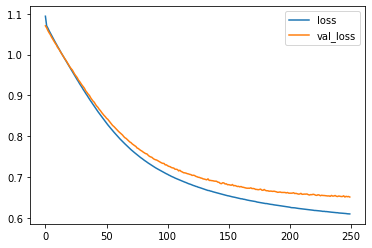

In [25]:
# review results
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))